# Simulating GMB paths
See Binomial Trees notebook for definition of GBM and
$$
S_{t}=S_{0} \operatorname{e x p} \biggl( \left( \mu-{\frac{\sigma^{2}} {2}} \right) t+\sigma W_{t} \biggr). 
$$
$W_{t}$ at different time points can be simulated by definition by adding independent Gaussians.

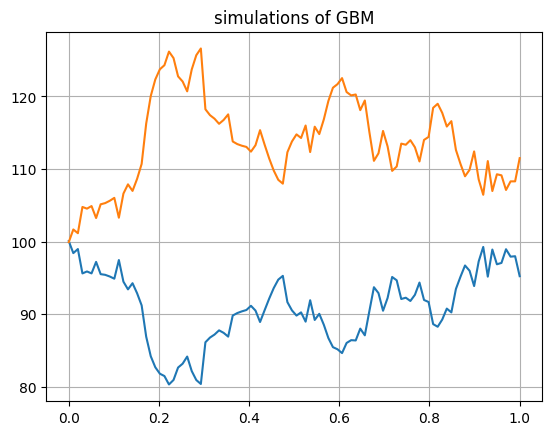

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_GBM_path(S0, mu, sigma, T, dt, num_paths):
    """Simulate multiple paths of the geometric Brownian motion process S_{t}=S_{0} exp((r-sigma^2/2)t + sigma*W_{t})"""
    N = round(T/dt)
    t = np.linspace(0, T, N)
    W = np.random.standard_normal(size = (num_paths, N)) 
    W = np.cumsum(W, axis=1)*np.sqrt(dt) ### standard brownian motion
    X = (mu - 0.5*sigma**2)*t + sigma*W 
    S = S0*np.exp(X) ### geometric brownian motion
    return S

def simulate_GBM_path_anti(S0, mu, sigma, T, dt, num_paths):
    """Simulate multiple paths of the geometric Brownian motion process S_{t}=S_{0} exp((r-sigma^2/2)t + sigma*W_{t})"""
    N = round(T/dt)
    t = np.linspace(0, T, N)
    W = np.random.standard_normal(size = (num_paths, N)) 
    W = np.cumsum(W, axis=1)*np.sqrt(dt) ### standard brownian motion
    W_anti = -W ### antithetic brownian motion
    X = (mu - 0.5*sigma**2)*t + sigma*W 
    X_anti = (mu - 0.5*sigma**2)*t + sigma*W_anti
    S = S0*np.exp(X) ### geometric brownian motion
    S_anti = S0*np.exp(X_anti) ### antithetic geometric brownian motion
    return np.concatenate((S, S_anti), axis=0)

# Example usage
np.random.seed(40)
S0,r,sigma,T,dt,num_paths = 100,0.05,0.2,1,0.01,1
paths = simulate_GBM_path(S0, r, sigma, T, dt, num_paths)
paths_anti = simulate_GBM_path_anti(S0, r, sigma, T, dt, num_paths)

# Plot the simulated geometric Brownian motion paths
for i in range(paths_anti.shape[0]):
    plt.plot(np.linspace(0,T,round(T/dt)),paths_anti[i, :])
    plt.grid(True)
    plt.title("simulations of GBM")
plt.show()


# Least-Square Monte Carlo

In [2]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


def payoff_put(S,K): return np.maximum(K-S,0)

def least_square_Monte_Carlo_put(paths,r,dt,T,K):
    value = payoff_put(paths[:,-1],K)
    for col in paths.T[:-1][::-1]:# stepping backwards in time
       value *= np.exp(-r*dt) # discounting 
       ITMmask = col < K # selects paths ITM
       ITMpaths = col[ITMmask]
       ITMvalue = value[ITMmask]
       model = LinearRegression()
       X = np.column_stack((ITMpaths,ITMpaths**2))
       model.fit(X,ITMvalue) # OLS of the continuation value
       interpolated = model.predict(X)
       exercised = payoff_put(ITMpaths,K)
       value[ITMmask] = np.where(interpolated>exercised, ITMvalue, exercised)

    return np.mean(value), np.std(value)/np.sqrt(len(value))
    

np.random.seed(42)

# example of binomial
S0,mu,sigma,T,dt,num_paths = 100,0.07,0.3,1,0.02,20000
r = 0.2
K = 110

# example of longstaff schwartz paper
# S0,mu,sigma,T,dt,num_paths = 36,0.06,0.2,1,0.02,5000
# r = 0.06
# K = 40

paths = simulate_GBM_path_anti(S0, mu, sigma, T, dt, num_paths)
val, std = least_square_Monte_Carlo_put(paths,r,dt,T,K)
print(val, std)

14.127322708654054 0.05495782879708914
